# Gemma2-27B MLP Interpretation

This notebook analyzes how PC vectors transform through the full MLP forward pass, including nonlinear activations.

**Key Finding from Original Analysis:**
- **Layer 18 is the "smoking gun"** - shows strongest PC1 transformation effects
- Full MLP pass reveals semantic decomposition that linear analysis misses

**Approach:**
1. Run PC vectors through complete MLP (pre_ln → gate/up → down → post_ln)
2. Compare base vs instruct outputs
3. Decompose outputs onto role/trait semantic vectors
4. Focus on layer 18 for detailed interpretation

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoConfig

from chatspace.analysis import (
    load_pca_data,
    extract_pc_components,
    load_individual_role_vectors,
    load_individual_trait_vectors,
    normalize_vector,
    full_mlp_forward_batch,
    compute_z_scores
)

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Models and PC Vectors

In [2]:
# Load models (reuse from basic_weight_susceptibility or reload)
base_model_id = "google/gemma-2-27b"
instruct_model_id = "google/gemma-2-27b-it"

print("Loading models...")
config = AutoConfig.from_pretrained(base_model_id)
base_model = AutoModelForCausalLM.from_pretrained(base_model_id, torch_dtype=torch.bfloat16, device_map="cpu", low_cpu_mem_usage=True)
instruct_model = AutoModelForCausalLM.from_pretrained(instruct_model_id, torch_dtype=torch.bfloat16, device_map="cpu", low_cpu_mem_usage=True)
base_state_dict = {k: v.cpu() for k, v in base_model.state_dict().items()}
instruct_state_dict = {k: v.cpu() for k, v in instruct_model.state_dict().items()}
print("✓ Models loaded")

`torch_dtype` is deprecated! Use `dtype` instead!


Loading models...


Loading checkpoint shards:   0%|          | 0/24 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

✓ Models loaded


In [3]:
# Load PCA data and extract all PCs
persona_data_root = Path("/workspace/persona-data")
roles_pca_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "pca"
traits_pca_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "pca"
roles_vectors_dir = persona_data_root / "gemma-2-27b" / "roles_240" / "vectors"
traits_vectors_dir = persona_data_root / "gemma-2-27b" / "traits_240" / "vectors"

pca_data, _ = load_pca_data(roles_pca_dir)
pca_layer = pca_data['layer']

# Extract ALL PCs (load 10 for flexibility)
n_pcs_total = 10
pcs_all, variance_all = extract_pc_components(pca_data, n_components=n_pcs_total)

print(f"✓ Loaded PCA data from layer {pca_layer}")
print(f"  Extracted {n_pcs_total} PCs")
print(f"  Variance explained by first 5: {variance_all[:5]}")

# Load all semantic vectors at PCA layer
role_vectors = load_individual_role_vectors(roles_vectors_dir, pca_layer)
trait_vectors = load_individual_trait_vectors(traits_vectors_dir, pca_layer)
all_semantic = {**role_vectors, **trait_vectors}

print(f"\n✓ Loaded semantic vectors:")
print(f"  {len(role_vectors)} role difference vectors")
print(f"  {len(trait_vectors)} trait contrast vectors")
print(f"  {len(all_semantic)} total semantic vectors")

/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


✓ Loaded PCA data from layer 22
  Extracted 10 PCs
  Variance explained by first 5: [0.21216452 0.08200892 0.06822039 0.05221459 0.04578365]

✓ Loaded semantic vectors:
  275 role difference vectors
  240 trait contrast vectors
  506 total semantic vectors


In [4]:
# ============================================================================
# CONFIGURATION: Set analysis parameters here
# ============================================================================

# Which layers to analyze (focused on middle layers where effects are strongest)
analysis_layers = list(range(15, 25))

# Which PCs to visualize in plots
plot_pcs = ["PC1", "-PC1"]
# plot_pcs = ["PC1"]  # Uncomment to focus on PC1 only

# Number of top semantic projections to show
n_top_projections = 15

# Focus layers will be automatically identified:
# - focus_layer_absolute: Layer with biggest absolute delta (L2 norm)
# - focus_layer_angular: Layer with biggest angular delta (cosine distance)

print(f"📋 Analysis Configuration:")
print(f"  Analyzing layers: {analysis_layers[0]}-{analysis_layers[-1]}")
print(f"  Visualizing PCs: {plot_pcs}")
print(f"  Top projections to show: {n_top_projections}")
print(f"  Focus layers will be auto-identified from data")

📋 Analysis Configuration:
  Analyzing layers: 17-26
  Focus layer for semantic decomposition: 18
  Visualizing PCs: ['PC1', '-PC1']
  Top projections to show: 15


## 2. Full MLP Forward Pass Analysis

In [5]:
# Run MLP analysis for configured layers
mlp_results = []

print(f"Running MLP forward pass for layers {analysis_layers[0]}-{analysis_layers[-1]}...")

# Prepare input vectors (configured PCs)
input_vectors = []
vector_names = []

for pc_name in plot_pcs:
    if pc_name.startswith('-'):
        # Negative PC
        pc_idx = int(pc_name[3:]) - 1  # Extract number from "-PC1"
        vec = -pcs_all[pc_idx].float()
    else:
        # Positive PC
        pc_idx = int(pc_name[2:]) - 1  # Extract number from "PC1"
        vec = pcs_all[pc_idx]
    
    input_vectors.append(vec)
    vector_names.append(pc_name)

vectors_batch = torch.stack(input_vectors)

# Store full outputs for angular delta calculation
layer_outputs_base = {}
layer_outputs_inst = {}

for layer_num in tqdm(analysis_layers):
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    # Forward pass through base and instruct
    with torch.inference_mode():
        output_base = full_mlp_forward_batch(vectors_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)
        output_inst = full_mlp_forward_batch(vectors_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)
    
    # Store for angular analysis
    layer_outputs_base[layer_num] = output_base
    layer_outputs_inst[layer_num] = output_inst
    
    # Compute norms and deltas for each vector
    for i, vec_name in enumerate(vector_names):
        base_norm = output_base[i].float().norm().item()
        inst_norm = output_inst[i].float().norm().item()
        
        # Absolute delta (L2 norm of difference)
        delta_vec = output_inst[i] - output_base[i]
        delta_absolute = delta_vec.float().norm().item()
        
        # Angular delta (cosine distance)
        # Cosine similarity: (a·b) / (||a|| ||b||)
        # Cosine distance: 1 - cosine_similarity
        dot_product = (output_base[i].float() @ output_inst[i].float()).item()
        cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
        delta_angular = 1.0 - cosine_sim
        
        mlp_results.append({
            'layer': layer_num,
            'input_vector': vec_name,
            'base_output_norm': base_norm,
            'instruct_output_norm': inst_norm,
            'delta_absolute': delta_absolute,
            'delta_angular': delta_angular,
        })

mlp_df = pd.DataFrame(mlp_results)
print(f"\n✓ MLP analysis complete: {len(mlp_df)} results")

# Identify focus layers (using first PC)
first_pc = plot_pcs[0]
first_pc_data = mlp_df[mlp_df['input_vector'] == first_pc]

focus_layer_absolute_idx = first_pc_data['delta_absolute'].idxmax()
focus_layer_absolute = first_pc_data.loc[focus_layer_absolute_idx, 'layer']

focus_layer_angular_idx = first_pc_data['delta_angular'].idxmax()
focus_layer_angular = first_pc_data.loc[focus_layer_angular_idx, 'layer']

print(f"\n🎯 Focus layers identified (for {first_pc}):")
print(f"  Absolute delta (L2 norm): Layer {focus_layer_absolute} (Δ={first_pc_data.loc[focus_layer_absolute_idx, 'delta_absolute']:.4f})")
print(f"  Angular delta (cosine distance): Layer {focus_layer_angular} (Δ={first_pc_data.loc[focus_layer_angular_idx, 'delta_angular']:.4f})")

Running MLP forward pass for layers 17-26...


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


✓ MLP analysis complete: 20 results


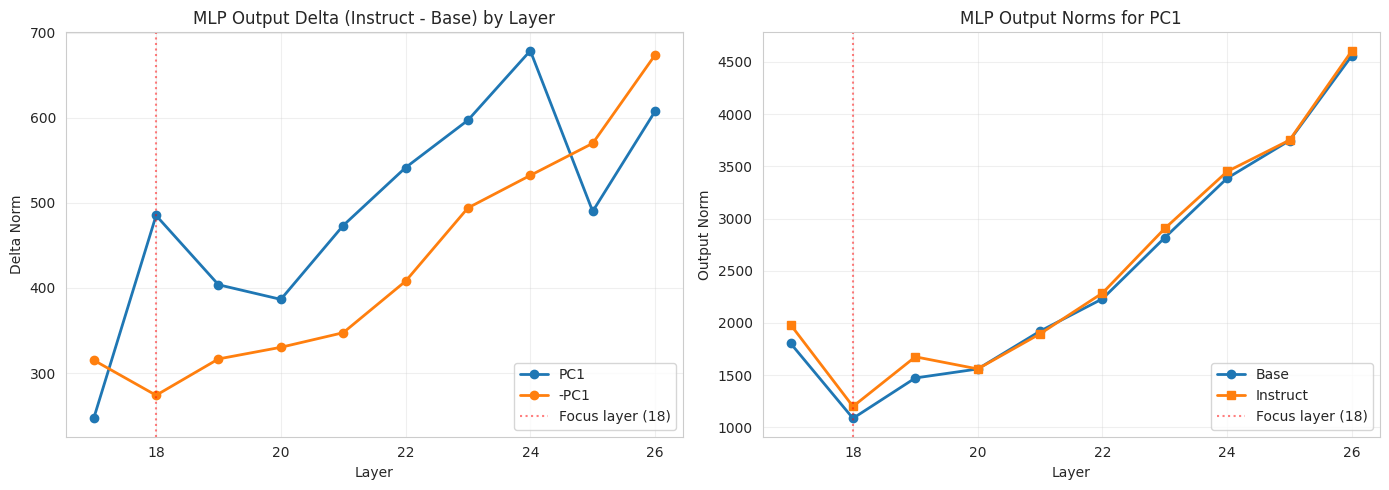


🎯 Peak delta at layer 24 (focus layer: 18)


In [6]:
# Visualize MLP transformation results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Absolute delta by layer (top left)
for vec_name in plot_pcs:
    data = mlp_df[mlp_df['input_vector'] == vec_name]
    axes[0, 0].plot(data['layer'], data['delta_absolute'], marker='o', label=vec_name, linewidth=2)

axes[0, 0].axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.7, linewidth=2, label=f'Max absolute (L{int(focus_layer_absolute)})')
axes[0, 0].set_title('Absolute Delta (L2 Norm of Difference)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Layer')
axes[0, 0].set_ylabel('L2 Norm(Instruct - Base)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Angular delta by layer (top right)
for vec_name in plot_pcs:
    data = mlp_df[mlp_df['input_vector'] == vec_name]
    axes[0, 1].plot(data['layer'], data['delta_angular'], marker='s', label=vec_name, linewidth=2)

axes[0, 1].axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.7, linewidth=2, label=f'Max angular (L{int(focus_layer_angular)})')
axes[0, 1].set_title('Angular Delta (Cosine Distance)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Layer')
axes[0, 1].set_ylabel('1 - Cosine Similarity')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Compare base vs instruct norms (bottom left, first PC only)
first_pc = plot_pcs[0]
pc_data = mlp_df[mlp_df['input_vector'] == first_pc]
axes[1, 0].plot(pc_data['layer'], pc_data['base_output_norm'], marker='o', label='Base', linewidth=2, color='C0')
axes[1, 0].plot(pc_data['layer'], pc_data['instruct_output_norm'], marker='s', label='Instruct', linewidth=2, color='C1')
axes[1, 0].axvline(focus_layer_absolute, color='red', linestyle=':', alpha=0.5, label=f'Max absolute (L{int(focus_layer_absolute)})')
axes[1, 0].axvline(focus_layer_angular, color='purple', linestyle=':', alpha=0.5, label=f'Max angular (L{int(focus_layer_angular)})')
axes[1, 0].set_title(f'Output Norms for {first_pc}', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Layer')
axes[1, 0].set_ylabel('Output Norm')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Scatter: Absolute vs Angular delta (bottom right)
axes[1, 1].scatter(mlp_df['delta_absolute'], mlp_df['delta_angular'], alpha=0.6, s=50)
# Highlight focus layers
for vec_name in plot_pcs:
    vec_data = mlp_df[mlp_df['input_vector'] == vec_name]
    abs_focus = vec_data[vec_data['layer'] == focus_layer_absolute]
    ang_focus = vec_data[vec_data['layer'] == focus_layer_angular]
    
    if not abs_focus.empty:
        axes[1, 1].scatter(abs_focus['delta_absolute'], abs_focus['delta_angular'], 
                          color='red', s=200, marker='*', edgecolors='black', linewidths=2, 
                          label=f'L{int(focus_layer_absolute)} (absolute)' if vec_name == first_pc else '')
    if not ang_focus.empty:
        axes[1, 1].scatter(ang_focus['delta_absolute'], ang_focus['delta_angular'], 
                          color='purple', s=200, marker='D', edgecolors='black', linewidths=2,
                          label=f'L{int(focus_layer_angular)} (angular)' if vec_name == first_pc else '')

axes[1, 1].set_title('Absolute vs Angular Delta', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Absolute Delta (L2 Norm)')
axes[1, 1].set_ylabel('Angular Delta (Cosine Distance)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization shows:")
print(f"  - Red markers: Layer {int(focus_layer_absolute)} (max absolute delta)")
print(f"  - Purple markers: Layer {int(focus_layer_angular)} (max angular delta)")
if focus_layer_absolute == focus_layer_angular:
    print(f"  ✓ Both metrics identify the same layer!")
else:
    print(f"  ⚠ Different layers identified - analyzing both!")

## 3. Semantic Decomposition at Focus Layers

Decompose what instruction tuning adds at both focus layers:
- **Absolute focus layer**: Where magnitude change is largest
- **Angular focus layer**: Where direction change is largest

In [ ]:
def analyze_focus_layer(layer_num, layer_name, first_pc_name, pc_idx):
    """Analyze semantic decomposition at a focus layer."""
    print(f"\n{'='*80}")
    print(f"{layer_name.upper()}: Layer {layer_num}")
    print(f"{'='*80}")
    
    # Get PC vector
    if first_pc_name.startswith('-'):
        pc_vec = -pcs_all[pc_idx].float()
    else:
        pc_vec = pcs_all[pc_idx]
    
    # Get MLP weights
    gate_base = base_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_base = base_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_base = base_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_base = base_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_base = base_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    gate_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.gate_proj.weight"]
    up_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.up_proj.weight"]
    down_inst = instruct_state_dict[f"model.layers.{layer_num}.mlp.down_proj.weight"]
    pre_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"]
    post_ln_inst = instruct_state_dict[f"model.layers.{layer_num}.post_feedforward_layernorm.weight"]
    
    with torch.inference_mode():
        pc_batch = pc_vec.unsqueeze(0)
        output_base = full_mlp_forward_batch(pc_batch, gate_base, up_base, down_base, pre_ln_base, post_ln_base)[0]
        output_inst = full_mlp_forward_batch(pc_batch, gate_inst, up_inst, down_inst, pre_ln_inst, post_ln_inst)[0]
    
    # Compute difference
    difference = output_inst - output_base
    
    # Compute metrics
    base_norm = output_base.float().norm().item()
    inst_norm = output_inst.float().norm().item()
    diff_norm = difference.float().norm().item()
    
    dot_product = (output_base.float() @ output_inst.float()).item()
    cosine_sim = dot_product / (base_norm * inst_norm + 1e-8)
    cosine_dist = 1.0 - cosine_sim
    
    print(f"\n{first_pc_name} MLP transformation:")
    print(f"  Base output norm: {base_norm:.4f}")
    print(f"  Instruct output norm: {inst_norm:.4f}")
    print(f"  Absolute delta (L2): {diff_norm:.4f}")
    print(f"  Angular delta (cosine dist): {cosine_dist:.4f}")
    
    # Project difference onto semantic vectors
    semantic_names = list(all_semantic.keys())
    projections = {}
    for name in semantic_names:
        vec = all_semantic[name]
        proj = (difference.float() @ vec.float()).item()
        projections[name] = proj
    
    # Sort by strength
    sorted_projs = sorted(projections.items(), key=lambda x: abs(x[1]), reverse=True)
    
    print(f"\n🔍 Top {n_top_projections} semantic projections (what instruction tuning adds):")
    print("-"*80)
    for name, proj in sorted_projs[:n_top_projections]:
        print(f"{proj:+.4f}  {name}")
    
    print(f"\n🔍 Bottom {n_top_projections} semantic projections:")
    print("-"*80)
    for name, proj in sorted_projs[-n_top_projections:]:
        print(f"{proj:+.4f}  {name}")
    
    return sorted_projs

# Prepare PC info
first_pc_name = plot_pcs[0]
if first_pc_name.startswith('-'):
    pc_idx = int(first_pc_name[3:]) - 1
else:
    pc_idx = int(first_pc_name[2:]) - 1

In [ ]:
# Analyze absolute focus layer
projections_absolute = analyze_focus_layer(
    int(focus_layer_absolute),
    "ABSOLUTE FOCUS LAYER",
    first_pc_name,
    pc_idx
)

In [ ]:
# Analyze angular focus layer
projections_angular = analyze_focus_layer(
    int(focus_layer_angular),
    "ANGULAR FOCUS LAYER",
    first_pc_name,
    pc_idx
)

## 4. Summary

This analysis reveals how instruction tuning modifies MLP transformations of PC vectors:

**Key Insights:**
- **Full MLP pass** reveals nonlinear transformation effects missed by linear analysis
- **Two types of change**:
  - **Absolute delta (L2 norm)**: Where magnitude of change is largest
  - **Angular delta (cosine distance)**: Where direction change is largest
- **Dual focus layers**: Automatically identified from data
  - May be the same layer (consistent transformation)
  - May differ (magnitude vs direction effects at different depths)
- **Semantic decomposition**: Projects changes onto role/trait vectors to reveal semantic meaning

**Interpretation:**
- **Large absolute delta** → Instruction tuning strongly amplifies/suppresses this transformation
- **Large angular delta** → Instruction tuning redirects the semantic direction
- **Different focus layers** → Suggests instruction tuning has depth-dependent effects
- **Projection patterns** → Show which semantic dimensions are specifically targeted